<a href="https://colab.research.google.com/github/taechanha/inverseDesignMetaMatl/blob/main/%5Br%5D_index_list_%26_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################

import numpy as np
import matplotlib.pyplot as plt

f = open("/content/dataset_2.txt", 'r')
data = []
length = 0
for i in f:
  new = []
  new.append(i)
  data.append(new)
  # length of dataset
  length += 1

f.close()

# create dataset from data
dataset = []
for i in range(length):
  new = []
  for j in data[i][0].split(','):
    new.append(float(j))
  dataset.append(new)

print("shape of dataset: ", np.array(dataset).shape)
edge_index = dataset

# trim out label from dataset
# Ex Ey Ez
label = []
new = []
for line in dataset:
  tmp = []
  tmp.append(line.pop(-1))
  tmp.append(line.pop(-1))
  tmp.append(line.pop(-1))
  tmp.reverse()
  label.append(tmp)

print("label.shape: ", np.array(label).shape)

# figure out max length of index list
max = 0
for i in dataset:
    if max < np.sum(i):
        max = np.sum(i)
max = int(max)
print("max: ", max)

# create index list dataset
d_tmp = []
for i in dataset:
    tmp = []
    for e, j in enumerate(i):
        if j == 1:
            tmp.append(e+1)
    if len(tmp) < max:
        tmp += [0] * (max - len(tmp))
    d_tmp.append(tmp)
print("shape of idx_list: ", np.array(d_tmp).shape)
idx_list = d_tmp


# whole dataset to Tensor & train/test split
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

idx_list = torch.FloatTensor(idx_list)
label = torch.FloatTensor(label)

split = int(length * 0.8)

x_train = idx_list[:split]
y_train = label[:split]
x_val = idx_list[split:]
y_val = label[split:]

print("x_train, y_train, x_val shape: ", x_train.shape, y_train.shape, x_val.shape)

# create torch dataset
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, label, dataset, transform=None, target_transform=None):
        self.labels = label
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.labels[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

# create DataLoader
from torch.utils.data import DataLoader

training_data   = CustomDataset(label=y_train, dataset=x_train)
test_data       = CustomDataset(label=y_val, dataset=x_val)
train_loader    = DataLoader(training_data, batch_size=4, shuffle=True)
test_loader     = DataLoader(test_data, batch_size=4, shuffle=False)

shape of dataset:  (2000, 354)
label.shape:  (2000, 3)
max:  32
shape of idx_list:  (2000, 32)
x_train, y_train, x_val shape:  torch.Size([1600, 32]) torch.Size([1600, 3]) torch.Size([400, 32])


In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(32, 3)
        #self.fc2 = nn.Linear(16, 20)
        #self.fc3 = nn.Linear(20, 10)
        #self.fc4 = nn.Linear(6, 3)

        nn.init.xavier_uniform_(self.fc1.weight)
        #nn.init.xavier_uniform_(self.fc2.weight)
        #nn.init.xavier_uniform_(self.fc3.weight)
        #nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 32))
        return x
        
        # x = F.leaky_relu(x)
        # x = self.fc2(x)
        # x = F.leaky_relu(x)
        # x = self.fc3(x)
        
        # return self.fc4(x)


model = DNN().cuda()
print(model)

DNN(
  (fc1): Linear(in_features=32, out_features=3, bias=True)
)


In [64]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

99

In [81]:
def train(model, train_losses, epoch):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        x, y = x.cuda().float(), y.cuda()
        optimizer.zero_grad()
        o = model(x)
        loss = loss_function(o, y)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print('====> Epoch: {} loss: {:.4f}'.format(e, train_loss / len(train_loader)))
    train_losses.append(train_loss / len(train_loader))

def test(model, val_losses):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda().float(), y.cuda()       
            o = model(x)
            loss = loss_function(o, y)
            
            test_loss += loss.item()
    print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))
    val_losses.append(test_loss / len(test_loader))


def test_pred(model):
    y_pred = []
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda().float(), y.cuda()       
            o = model(x)
            y_pred.append(o)

            loss = loss_function(o, y)
            test_loss += loss.item()
    print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

    return y_pred

In [86]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.000001)
loss_function = nn.MSELoss()
epochs = 200

# for loss plot
#tloss = []
#vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 19.1995
====> Test set loss: 19.6791
====> Epoch: 2 loss: 19.1930
====> Test set loss: 19.6757
====> Epoch: 3 loss: 19.1906
====> Test set loss: 19.6731
====> Epoch: 4 loss: 19.1899
====> Test set loss: 19.6730
====> Epoch: 5 loss: 19.1875
====> Test set loss: 19.6719
====> Epoch: 6 loss: 19.1864
====> Test set loss: 19.6698
====> Epoch: 7 loss: 19.1863
====> Test set loss: 19.6708
====> Epoch: 8 loss: 19.1846
====> Test set loss: 19.6690
====> Epoch: 9 loss: 19.1852
====> Test set loss: 19.6704
====> Epoch: 10 loss: 19.1850
====> Test set loss: 19.6690
====> Epoch: 11 loss: 19.1822
====> Test set loss: 19.6682
====> Epoch: 12 loss: 19.1844
====> Test set loss: 19.6662
====> Epoch: 13 loss: 19.1814
====> Test set loss: 19.6644
====> Epoch: 14 loss: 19.1813
====> Test set loss: 19.6649
====> Epoch: 15 loss: 19.1806
====> Test set loss: 19.6647
====> Epoch: 16 loss: 19.1808
====> Test set loss: 19.6618
====> Epoch: 17 loss: 19.1791
====> Test set loss: 19.6616
====> 

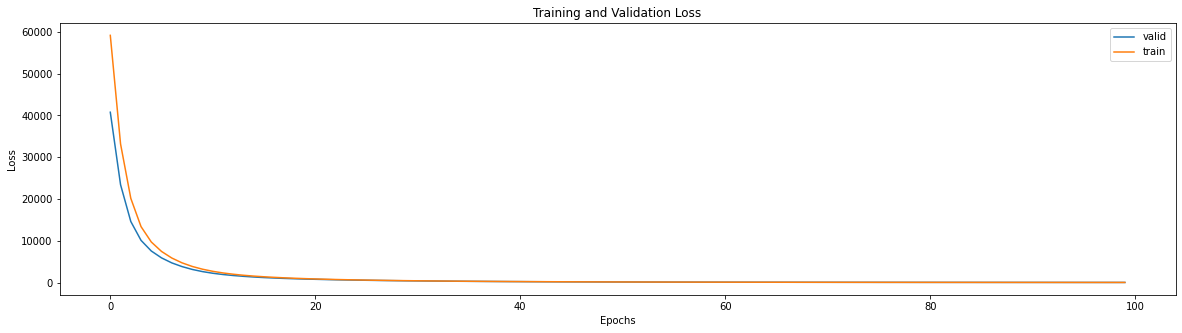

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss[:100]), label="valid")
plt.plot(np.array(tloss[:100]), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [88]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o, y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 4.2923


In [94]:
y1 = y_pred

In [89]:
###

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 3)
        #self.fc3 = nn.Linear(20, 10)
        #self.fc4 = nn.Linear(6, 3)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        #nn.init.xavier_uniform_(self.fc3.weight)
        #nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 32))
        x = F.leaky_relu(x)
        x = self.fc2(x)
        return x
        
        # x = F.leaky_relu(x)
        # x = self.fc2(x)
        # x = F.leaky_relu(x)
        # x = self.fc3(x)
        
        # return self.fc4(x)


model = DNN().cuda()
print(model)

DNN(
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)


In [111]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

579

In [112]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.MSELoss()
epochs = 100

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 12371.0539
====> Test set loss: 5269.3021
====> Epoch: 2 loss: 4440.4066
====> Test set loss: 3709.7556
====> Epoch: 3 loss: 3306.5238
====> Test set loss: 2947.9997
====> Epoch: 4 loss: 2662.3613
====> Test set loss: 2422.2388
====> Epoch: 5 loss: 2189.3978
====> Test set loss: 1994.3774
====> Epoch: 6 loss: 1821.6527
====> Test set loss: 1666.7235
====> Epoch: 7 loss: 1531.2354
====> Test set loss: 1415.2260
====> Epoch: 8 loss: 1298.3178
====> Test set loss: 1209.6340
====> Epoch: 9 loss: 1108.2376
====> Test set loss: 1048.8004
====> Epoch: 10 loss: 949.6221
====> Test set loss: 895.9223
====> Epoch: 11 loss: 815.6579
====> Test set loss: 769.7947
====> Epoch: 12 loss: 702.2448
====> Test set loss: 667.4340
====> Epoch: 13 loss: 607.4261
====> Test set loss: 569.4479
====> Epoch: 14 loss: 529.1057
====> Test set loss: 503.3509
====> Epoch: 15 loss: 463.1710
====> Test set loss: 437.6964
====> Epoch: 16 loss: 408.4856
====> Test set loss: 386.6633
====> Epoch: 1

In [113]:
y2 = y_pred

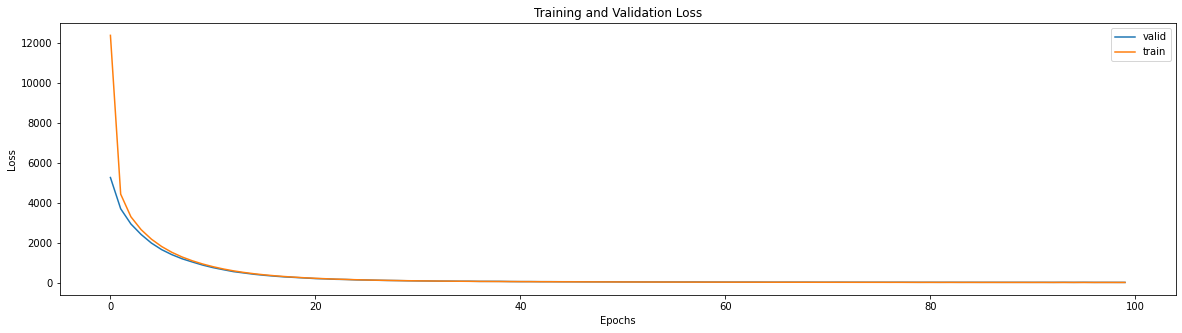

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss[:100]), label="valid")
plt.plot(np.array(tloss[:100]), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [115]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o, y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 5.3682


In [106]:
###

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 3)
        #self.fc4 = nn.Linear(6, 3)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        #nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 32))
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return x
        
        # x = F.leaky_relu(x)
        # x = self.fc2(x)
        # x = F.leaky_relu(x)
        # x = self.fc3(x)
        
        # return self.fc4(x)


model = DNN().cuda()
print(model)

DNN(
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
)


In [117]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

691

In [118]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.MSELoss()
epochs = 100

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 1116.5112
====> Test set loss: 413.0468
====> Epoch: 2 loss: 354.6416
====> Test set loss: 241.0939
====> Epoch: 3 loss: 229.8483
====> Test set loss: 184.0294
====> Epoch: 4 loss: 179.3397
====> Test set loss: 154.4441
====> Epoch: 5 loss: 150.2094
====> Test set loss: 134.1534
====> Epoch: 6 loss: 124.6312
====> Test set loss: 115.2377
====> Epoch: 7 loss: 99.3890
====> Test set loss: 94.5635
====> Epoch: 8 loss: 82.4076
====> Test set loss: 82.4733
====> Epoch: 9 loss: 72.7941
====> Test set loss: 74.9084
====> Epoch: 10 loss: 66.4816
====> Test set loss: 69.3787
====> Epoch: 11 loss: 61.6820
====> Test set loss: 65.2089
====> Epoch: 12 loss: 57.4934
====> Test set loss: 60.8233
====> Epoch: 13 loss: 53.5338
====> Test set loss: 56.7607
====> Epoch: 14 loss: 49.5902
====> Test set loss: 52.7002
====> Epoch: 15 loss: 45.5234
====> Test set loss: 47.9889
====> Epoch: 16 loss: 41.2137
====> Test set loss: 42.9445
====> Epoch: 17 loss: 36.7023
====> Test set loss: 3

In [119]:
y3 = y_pred

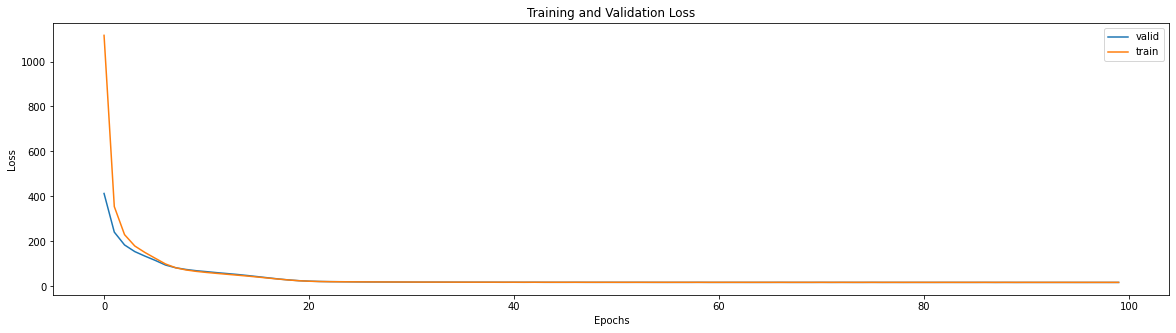

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss[:100]), label="valid")
plt.plot(np.array(tloss[:100]), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [121]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o, y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 4.0267


In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(32, 24)
        self.fc2 = nn.Linear(24, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 3)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 32))
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        return x
        
        # x = F.leaky_relu(x)
        # x = self.fc2(x)
        # x = F.leaky_relu(x)
        # x = self.fc3(x)
        
        # return self.fc4(x)


model = DNN().cuda()
print(model)

DNN(
  (fc1): Linear(in_features=32, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=3, bias=True)
)


In [123]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

1355

In [124]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.MSELoss()
epochs = 100

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 395.0941
====> Test set loss: 143.4903
====> Epoch: 2 loss: 122.8715
====> Test set loss: 113.4811
====> Epoch: 3 loss: 109.4442
====> Test set loss: 105.7488
====> Epoch: 4 loss: 103.1447
====> Test set loss: 99.9256
====> Epoch: 5 loss: 94.9098
====> Test set loss: 85.3108
====> Epoch: 6 loss: 48.5878
====> Test set loss: 31.7111
====> Epoch: 7 loss: 27.9286
====> Test set loss: 25.5379
====> Epoch: 8 loss: 24.3843
====> Test set loss: 23.4186
====> Epoch: 9 loss: 22.8585
====> Test set loss: 22.1151
====> Epoch: 10 loss: 21.9140
====> Test set loss: 21.2426
====> Epoch: 11 loss: 21.2983
====> Test set loss: 20.6424
====> Epoch: 12 loss: 20.7386
====> Test set loss: 20.3831
====> Epoch: 13 loss: 20.4168
====> Test set loss: 20.0404
====> Epoch: 14 loss: 20.1398
====> Test set loss: 19.9403
====> Epoch: 15 loss: 19.8494
====> Test set loss: 19.8502
====> Epoch: 16 loss: 19.6942
====> Test set loss: 19.7197
====> Epoch: 17 loss: 19.5172
====> Test set loss: 19.6392

In [125]:
y4 = y_pred

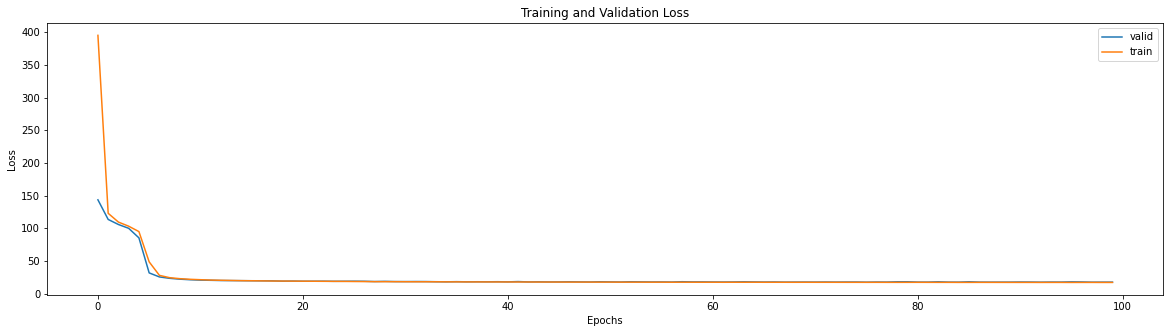

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss[:100]), label="valid")
plt.plot(np.array(tloss[:100]), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [127]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o, y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 4.0676


In [128]:
###

In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(32, 28)
        self.fc2 = nn.Linear(28, 20)
        self.fc3 = nn.Linear(20, 12)
        self.fc4 = nn.Linear(12, 6)
        self.fc5 = nn.Linear(6, 3)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.xavier_uniform_(self.fc5.weight)

    def forward(self, x):
        x = self.fc1(x.view(-1, 32))
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.leaky_relu(x)
        x = self.fc5(x)
        return x
        
        # x = F.leaky_relu(x)
        # x = self.fc2(x)
        # x = F.leaky_relu(x)
        # x = self.fc3(x)
        
        # return self.fc4(x)


model = DNN().cuda()
print(model)

DNN(
  (fc1): Linear(in_features=32, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=12, bias=True)
  (fc4): Linear(in_features=12, out_features=6, bias=True)
  (fc5): Linear(in_features=6, out_features=3, bias=True)
)


In [130]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

1855

In [131]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.MSELoss()
epochs = 100

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 2535.1817
====> Test set loss: 886.6764
====> Epoch: 2 loss: 523.2689
====> Test set loss: 311.5822
====> Epoch: 3 loss: 242.8313
====> Test set loss: 184.0063
====> Epoch: 4 loss: 170.0577
====> Test set loss: 146.6759
====> Epoch: 5 loss: 142.9076
====> Test set loss: 130.0523
====> Epoch: 6 loss: 128.5817
====> Test set loss: 121.5822
====> Epoch: 7 loss: 121.3090
====> Test set loss: 117.0951
====> Epoch: 8 loss: 117.3887
====> Test set loss: 114.3286
====> Epoch: 9 loss: 114.7092
====> Test set loss: 111.8047
====> Epoch: 10 loss: 111.6148
====> Test set loss: 108.4030
====> Epoch: 11 loss: 107.7696
====> Test set loss: 104.0072
====> Epoch: 12 loss: 102.3611
====> Test set loss: 97.2130
====> Epoch: 13 loss: 93.7407
====> Test set loss: 85.8899
====> Epoch: 14 loss: 78.7511
====> Test set loss: 66.2100
====> Epoch: 15 loss: 55.5640
====> Test set loss: 40.9294
====> Epoch: 16 loss: 35.3376
====> Test set loss: 27.7210
====> Epoch: 17 loss: 28.1954
====> Test 

In [132]:
y4 = y_pred

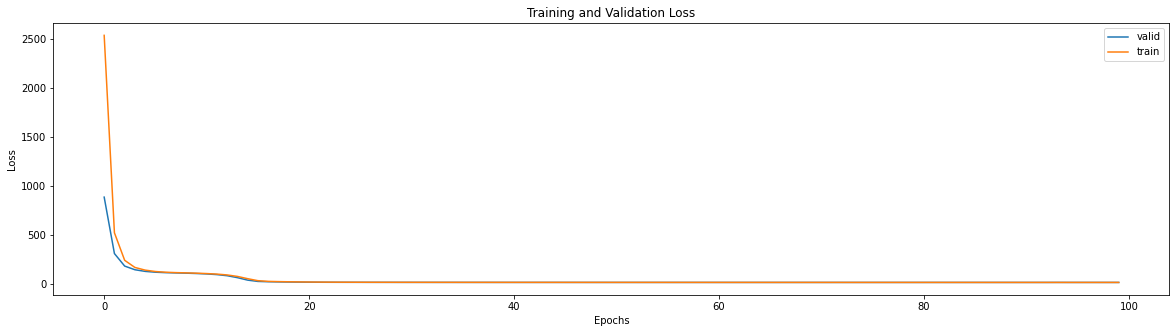

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss[:100]), label="valid")
plt.plot(np.array(tloss[:100]), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [134]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o, y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 4.0246


In [138]:
x, y = next(iter(test_loader))
o = model(x.cuda())
print(y)
print(o)

tensor([[20.4802, 13.7561,  9.1044],
        [12.0543,  0.6352,  7.2949],
        [12.8651, 11.9096,  8.6483],
        [14.9428,  6.6858,  3.0543]])
tensor([[10.3473, 10.8482,  9.7940],
        [ 4.2865,  4.5590,  4.2029],
        [ 8.0540,  8.3414,  8.0214],
        [ 8.3430,  8.5472,  8.1363]], device='cuda:0', grad_fn=<AddmmBackward>)
